## Introduction to problem 
How does an individual choose what hospital to go to if they have a condition which requires the individual to be admitted in for care? The natural answer comes down to how efficient a hospital is. One such measure of efficiency is Average Length of stay.The average length of stay in hospitals (ALOS) is often used as an indicator of efficiency. All other things being equal, a shorter stay will reduce the cost per discharge and shift care from inpatient to less expensive post acute settings. The ALOS refers to the average number of days that patients spend in hospital. It is generally measured by dividing the total number of days stayed by all inpatients during a year by the number of admissions or discharges. Day cases are excluded. The indicator is presented both for all acute care cases and for childbirth without complications.

In this assignment, the aim is to classify the ALOS in two categories, more than 3 days (True) or otherwise (False), this would help hospitals increase their efficiency and management.


In [1]:
# Importing required libraries and 
import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# Reading the data from CSV
# Ignoring column 'HealthServiceArea' (as indicated in the Assignment specification) and setting the ID as index column
# so that none of these columns are used as training attributes.
data = pd.read_csv('train_data.csv', index_col = 'ID', usecols = ['ID', 'Gender', 'Race', 'TypeOfAdmission', 'CCSProcedureCode',
                                                                  'APRSeverityOfIllnessCode', 'PaymentTypology', 'BirthWeight',
                                                                 'EmergencyDepartmentIndicator', 'AverageCostInCounty',
                                                                  'AverageChargesInCounty', 'AverageCostInFacility',
                                                                  'AverageChargesInFacility', 'AverageIncomeInZipCode', 'LengthOfStay'])

In [3]:
# Looking at the first few rows of the data
data.head()

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
ID,,,,,,,,,,,,,,
1,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1
2,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,1
3,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,1
4,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,1
5,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,1


In [4]:
# Checking the size of the dataset, if there are null values and the data types of various columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 1 to 59966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        59966 non-null  object
 1   Race                          59966 non-null  object
 2   TypeOfAdmission               59966 non-null  object
 3   CCSProcedureCode              59966 non-null  int64 
 4   APRSeverityOfIllnessCode      59966 non-null  int64 
 5   PaymentTypology               59966 non-null  object
 6   BirthWeight                   59966 non-null  int64 
 7   EmergencyDepartmentIndicator  59966 non-null  object
 8   AverageCostInCounty           59966 non-null  int64 
 9   AverageChargesInCounty        59966 non-null  int64 
 10  AverageCostInFacility         59966 non-null  int64 
 11  AverageChargesInFacility      59966 non-null  int64 
 12  AverageIncomeInZipCode        59966 non-null  int64 
 13  LengthOfStay    

After initial look at the data, it is evident that there are no *NULL* values. Having read the assignment specifications, it can be observed that the interpreted column types are not the most appropriate. For example *CCSProcedureCode* is a class of clinical procedure and should be converted to a categorical value. Similary, *APRSeverityOfIllnessCode* is an ordinal value on the scale of 1-4, 1 being the least severe. And finally *EmergencyDepartmentIndicator* is a boolean variable where Y represents True value.

The target variable *LengthOfStay* is also a boolean variable where if the length of stay is greater 3 days it is termed as 'not acute care level' or TRUE.

In the predictions the Target value has to be in 0 or 1 which I'll convert after the initial data exploration.

In [5]:
# Converting columns to correct datatypes based on attribute definitions in assignment specifications
data.CCSProcedureCode = data.CCSProcedureCode.astype('category')
severity_dtype = pd.api.types.CategoricalDtype(
    categories=[1, 2, 3, 4], ordered=True)
data.APRSeverityOfIllnessCode = data.APRSeverityOfIllnessCode.astype(severity_dtype)
data.loc[data.EmergencyDepartmentIndicator == "Y", "EmergencyDepartmentIndicator"] = True
data.loc[data.EmergencyDepartmentIndicator == "N", "EmergencyDepartmentIndicator"] = False
data.EmergencyDepartmentIndicator = data.EmergencyDepartmentIndicator.astype('bool')
data.LengthOfStay = data.LengthOfStay > 3

In [6]:
# Displaying the data information again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 1 to 59966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Gender                        59966 non-null  object  
 1   Race                          59966 non-null  object  
 2   TypeOfAdmission               59966 non-null  object  
 3   CCSProcedureCode              59966 non-null  category
 4   APRSeverityOfIllnessCode      59966 non-null  category
 5   PaymentTypology               59966 non-null  object  
 6   BirthWeight                   59966 non-null  int64   
 7   EmergencyDepartmentIndicator  59966 non-null  bool    
 8   AverageCostInCounty           59966 non-null  int64   
 9   AverageChargesInCounty        59966 non-null  int64   
 10  AverageCostInFacility         59966 non-null  int64   
 11  AverageChargesInFacility      59966 non-null  int64   
 12  AverageIncomeInZipCode        59966 non-null  

#### All the data types have been successfully converted and we can begin our exploratory data analysis
## First Glance at the data:
There are approximately 60K observations in the dataset with a total of 13 attributes for model training and 1 target variable.

There are apparently no *NULL* values which is a good sign.

The attributes are a good mix of boolean, categorical, ordinal and numeric type.

In [7]:
# Printing exploratory stats for all numeric columns in the dataset
data.describe()

,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
count,59966.000,59966.000,59966.000,59966.000,59966.000,59966.000
mean,3336.299,2372.807,7979.127,2396.414,7958.473,59.811
std,446.244,639.755,3220.291,1248.501,3859.295,21.470
min,2500.000,712.000,1243.000,457.000,1120.000,28.000
25%,3000.000,2041.000,4620.000,1551.000,4438.000,45.000
50%,3300.000,2533.000,9227.000,1967.000,7945.000,55.000
75%,3600.000,2785.000,10644.000,2895.000,11619.000,74.000
max,7500.000,3242.000,11381.000,8114.000,18466.000,115.000


#### Initial impressions
*BirthWeight* seems close to normal at first glance as mean and median values are fairly close. But a similar thing can not be said about other variables. Will explore this in cells below.

In [8]:
# Printing exploratory stats for non-numeric columns in the datset
data.describe(include=['object', 'category', 'boolean'])

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,EmergencyDepartmentIndicator,LengthOfStay
count,59966,59966,59966,59966,59966,59966,59966,59966
unique,3,4,4,7,4,9,2,2
top,M,White,Newborn,228,1,Medicaid,False,False
freq,30978,32943,58741,19886,47953,28723,59453,49895


##### Gender
Has a total of 3 unique values Male being the highest. Need to explore the frequency of other two categories.
##### Race
Has a total of 4 unique values White being the highest, which can be expected as the dataset is from the USA. Need to explore the frequency of other three categories.
##### TypeOfAdmission
Has a total of 4 unique values Newborn being the highest, and it seems almost all cases fall into this category (58741 of 59966). Need to explore the frequency of other three categories.
##### CCSProcedureCode
Has a total of 7 unique values 228 being the highest.
##### APRSeverityOfIllnessCode
Has a total of 4 unique values '1' being the highest.
##### PaymentTypology
Has a total of 9 unique values 'Medicaid' being the highest.
##### EmergencyDepartmentIndicator
Has a total of 2 unique values 'FALSE' being the highest, almost all cases fall in this category.
##### LengthOfStay
Has a total of 2 unique values 'FALSE' being the highest, which means most cases are acute care level. But quite clearly there will be a problem of class imbalance while training the ML model.


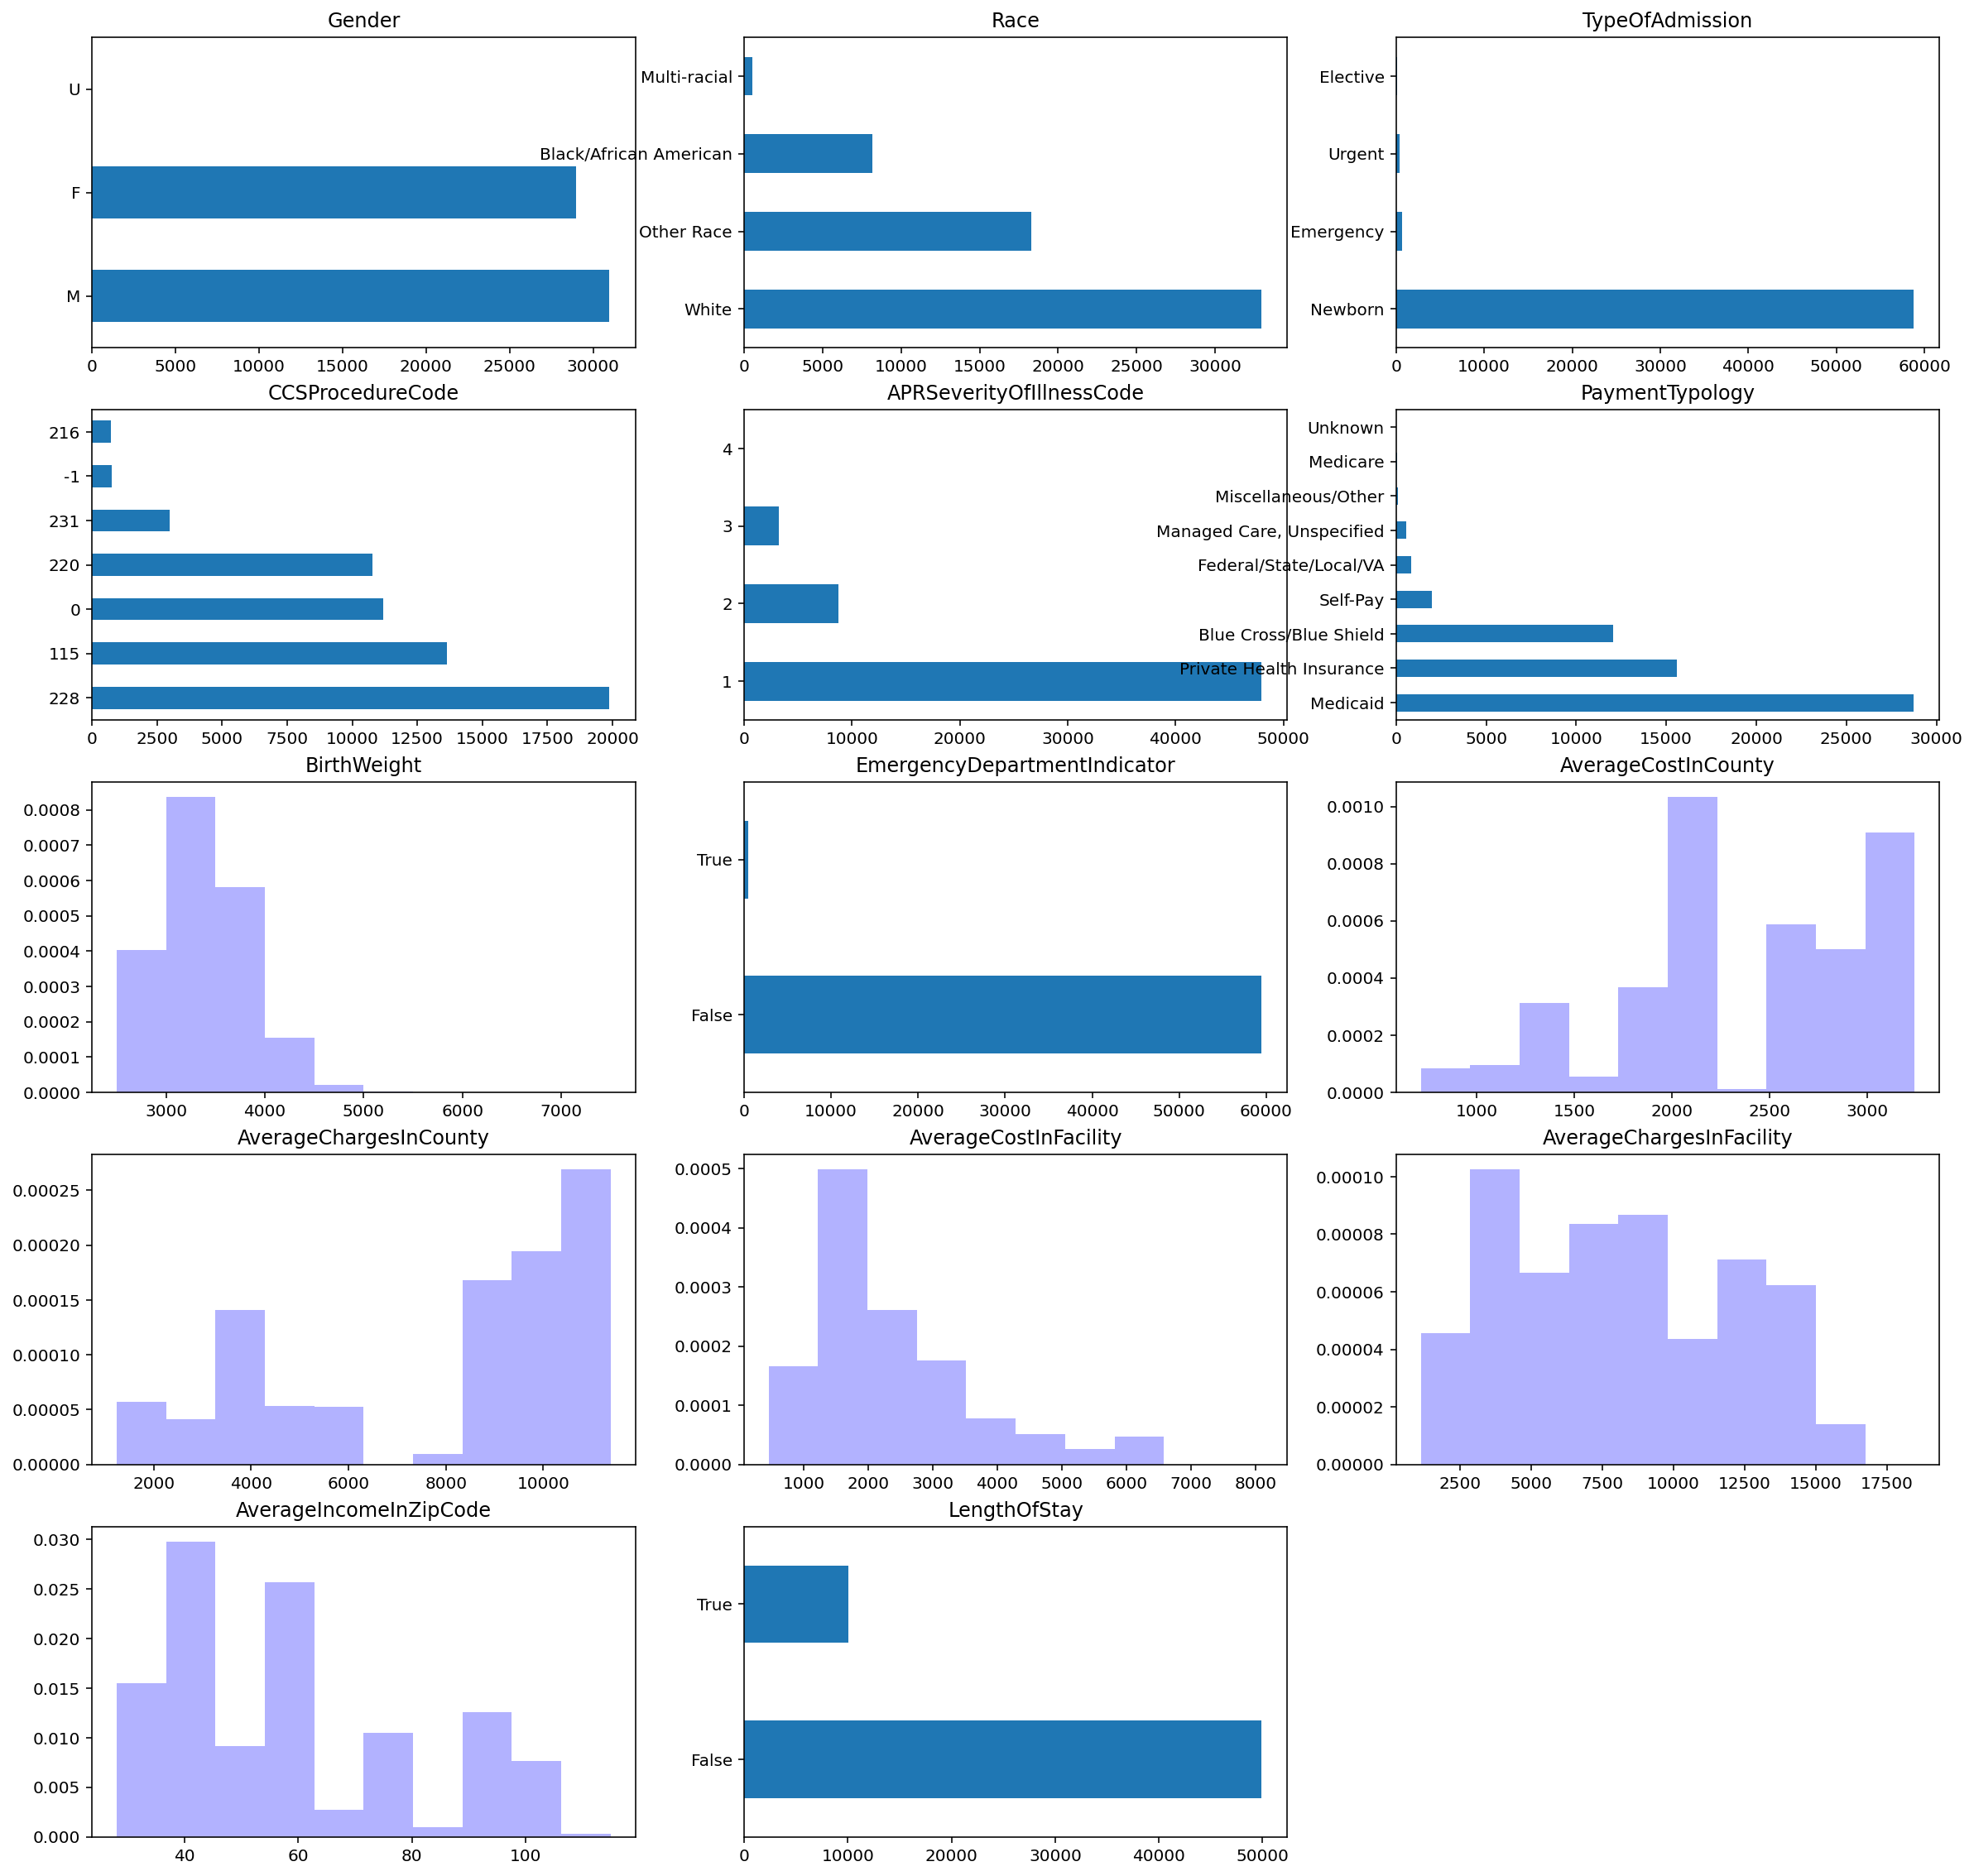

In [9]:
plt.figure(figsize=(20,20))
for i, column in enumerate(data.columns):
    plt.subplot(5,3,i+1)
    if data[column].dtype == bool:
        data[column].value_counts().plot.barh()
        plt.title(column)
    elif is_numeric_dtype(data[column]):
        plt.hist(data[column], alpha=0.3, color='b', density=True)
        plt.title(column)
    else:
        data[column].value_counts().plot.barh()
        plt.title(column)

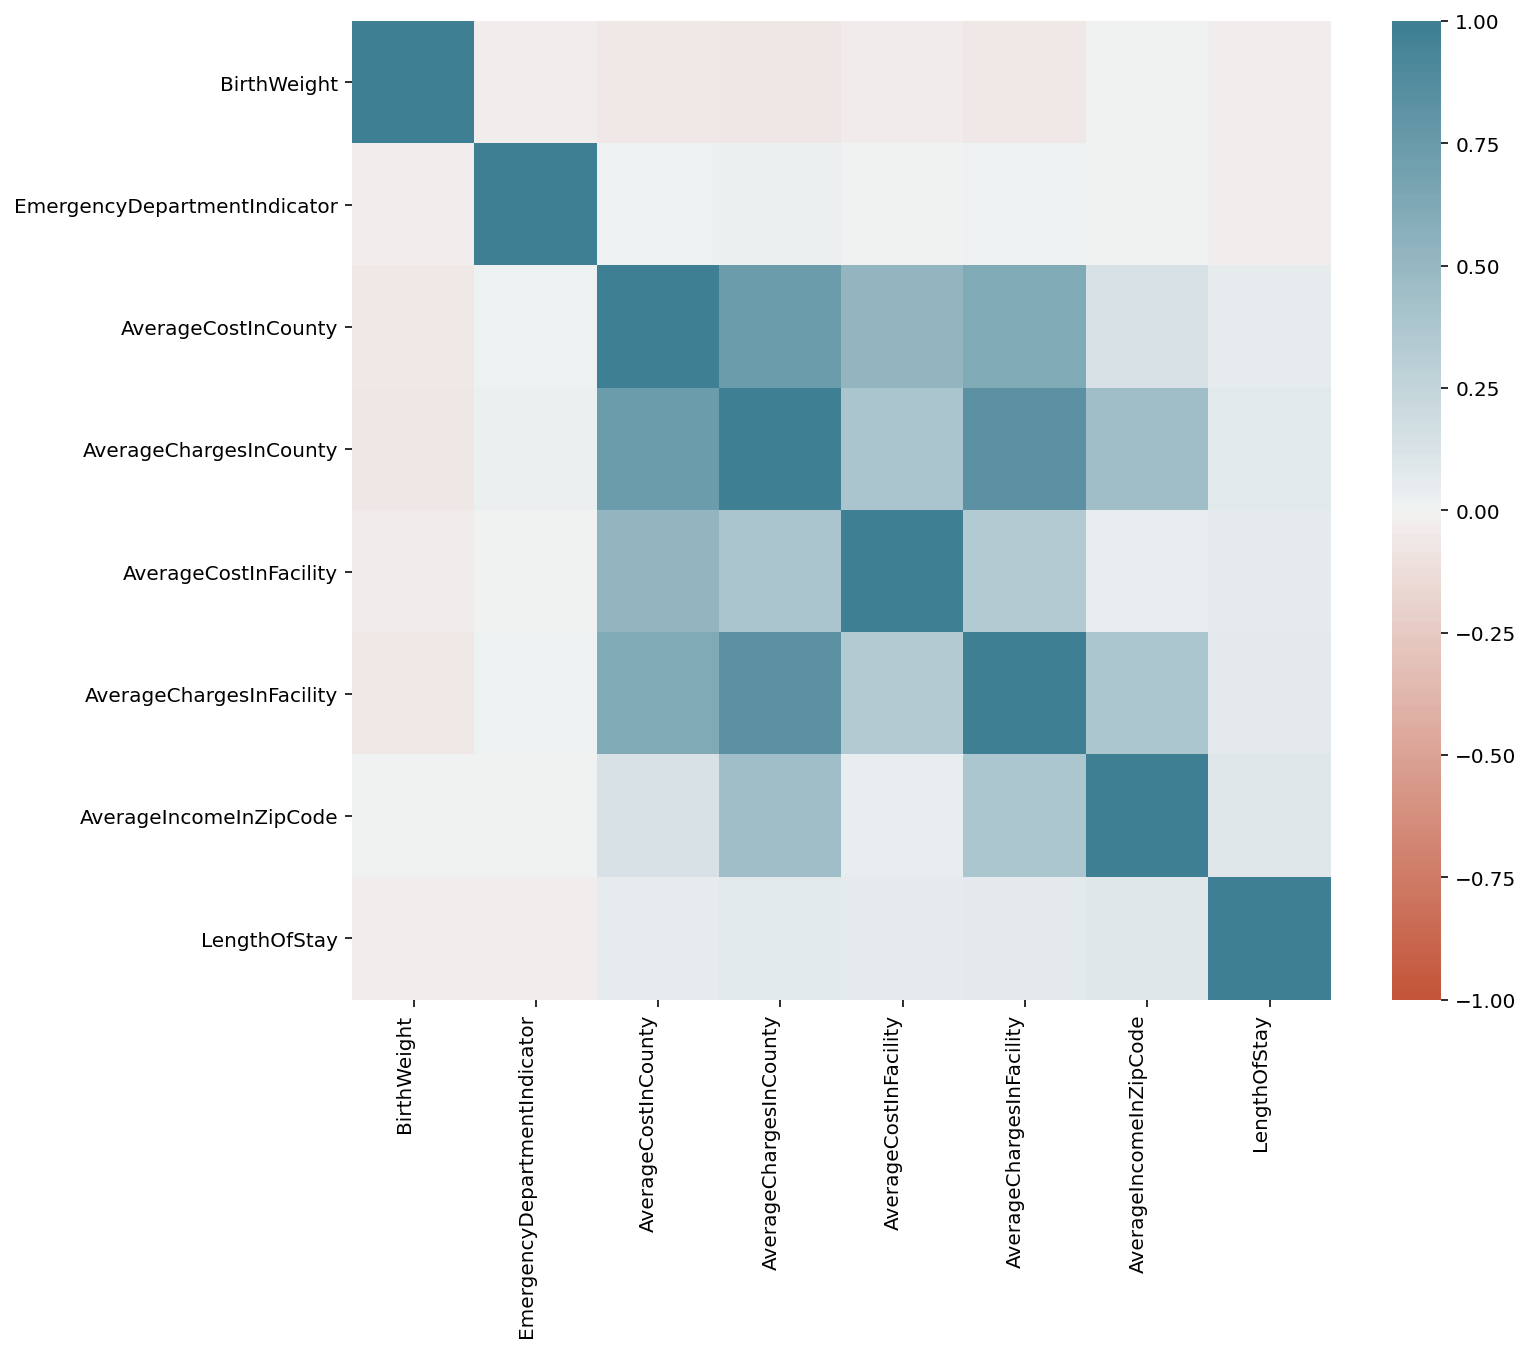

In [10]:
f, ax = plt.subplots(figsize=(11, 9))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);